In [1]:
import os
import math
import glob
import matplotlib
import numpy as np
import pandas as pd
import multiprocessing
import PersistenceImages.persistence_images as pimg
import scipy.integrate as integrate

from ripser import Rips
from matplotlib import cm
from scipy.io import loadmat
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [3]:
def get_sim_data(timefile, simulationtype):
    
    posfilestring = simulationtype + "/" + "Pos_" + str(timefile).zfill(7) +".dat"
    posdata = np.loadtxt(posfilestring, str, "#", ",")
    posx = []
    posy = []
    for val in posdata:
        splitpos = val.split("+")
        xpos = ""
        ypos = ""
        if(len(splitpos) == 2):
            xpos = splitpos[0]
            ypos = splitpos[1]
        else:
            minusindex = val[1:].find("-") + 1
            xpos = val[0:minusindex]
            ypos = val[minusindex:]
        ypos = ypos[:-1]
        xpos = [float(xpos)]
        ypos = [float(ypos)]
        posx = np.append(posx, xpos)
        posy = np.append(posy, ypos)   
    positions = np.column_stack((posx, posy))
    typefilestring = simulationtype + "/" + "Types_" + str(timefile).zfill(7) + ".dat"
    typedata = np.loadtxt(typefilestring, int, "#", ",")
    return (positions, typedata)

def compute_dim0_img(greenxpos, greenypos, redxpos, redypos, xpos, ypos, max_eps, px_res):
    
    vrc = Rips(maxdim = 0, thresh = max_eps, verbose = False)
    green_diag = vrc.fit_transform(np.transpose(np.array([greenxpos, greenypos])))
    red_diag = vrc.fit_transform(np.transpose(np.array([redxpos, redypos])))
    all_diag = vrc.fit_transform(np.transpose(np.array([xpos, ypos])))
    
    # replace inf with max eps
    # green_diag[0][-1] = [0.0, max_eps]
    # red_diag[0][-1] = [0.0, max_eps]
    # all_diag[0][-1] = [0.0, max_eps]

    # remove inf
    green_diag[0] = green_diag[0][:-1]
    red_diag[0] = red_diag[0][:-1]
    all_diag[0] = all_diag[0][:-1]
    
    pers_imager = pimg.PersistenceImager()
    pers_imager.pixel_size = px_res
    pers_imager.birth_range = (0, 1)
    pers_imager.pers_range = (0, max_eps)
    pers_imager.weight = pimg.weighting_fxns.persistence
    pers_imager.weight_params = {'n': 1}
    pers_imager.kernel_params = {'sigma': 0.05}
    
    green_pers_img = pers_imager.transform(green_diag[0], skew=False)
    red_pers_img = pers_imager.transform(red_diag[0], skew=False)
    all_pers_img = pers_imager.transform(all_diag[0], skew=False)
    
    return (green_pers_img, red_pers_img, all_pers_img)

def compute_pers_img(greenxpos, greenypos, redxpos, redypos, xpos, ypos, dim, max_eps, px_res):
    
    if dim == 0:
        return compute_dim0_img(greenxpos, greenypos, redxpos, redypos, xpos, ypos, max_eps, px_res)
    
    vrc = Rips(maxdim = dim, thresh = max_eps, verbose = False)
    green_diag = vrc.fit_transform(np.transpose(np.array([greenxpos, greenypos])))
    red_diag = vrc.fit_transform(np.transpose(np.array([redxpos, redypos])))
    all_diag = vrc.fit_transform(np.transpose(np.array([xpos, ypos])))
    
    pers_imager = pimg.PersistenceImager()
    pers_imager.pixel_size = px_res
    pers_imager.birth_range = (0, max_eps)
    pers_imager.pers_range = (0, max_eps/2)
    pers_imager.weight = pimg.weighting_fxns.persistence
    pers_imager.weight_params = {'n': 1}
    pers_imager.kernel_params = {'sigma': 0.05}
    # print(pers_imager)
    
    green_pers_img = pers_imager.transform(green_diag[dim], skew=True)
    red_pers_img = pers_imager.transform(red_diag[dim], skew=True)
    all_pers_img = pers_imager.transform(all_diag[dim], skew=True)
    
    return (green_pers_img, red_pers_img, all_pers_img)

def save_persimg(dim0_imgs, dim1_imgs, dim2_imgs, ofolder, ofilename):

    green_img_dim0, red_img_dim0, all_img_dim0 = dim0_imgs
    green_img_dim1, red_img_dim1, all_img_dim1 = dim1_imgs
    green_img_dim2, red_img_dim2, all_img_dim2 = dim2_imgs
    
    save_data = dict()
    save_data['H0'] = np.vstack([np.mean(green_img_dim0, axis=0), 
                                 np.mean(red_img_dim0, axis=0), 
                                 np.mean(all_img_dim0, axis=0)])
    save_data['H1'] = np.vstack([green_img_dim1.flatten(), 
                                 red_img_dim1.flatten(), 
                                 all_img_dim1.flatten()])
    save_data['H2'] = np.vstack([green_img_dim2.flatten(), 
                                 red_img_dim2.flatten(), 
                                 all_img_dim2.flatten()])
    
    with open(ofolder + os.sep + ofilename, 'wb') as fh:
        np.save(fh, save_data)
    
def visualize(posdata, dim0_imgs, dim1_imgs, dim2_imgs, max_eps, px_res, ofolder, ofilename):
    
    greenxpos, greenypos, redxpos, redypos = posdata
    green_img_dim0, red_img_dim0, all_img_dim0 = dim0_imgs
    green_img_dim1, red_img_dim1, all_img_dim1 = dim1_imgs
    green_img_dim2, red_img_dim2, all_img_dim2 = dim2_imgs
    
    green_intensity_vals = np.mean(green_img_dim0, axis=0)
    red_intensity_vals = np.mean(red_img_dim0, axis=0)
    all_intensity_vals = np.mean(all_img_dim0, axis=0)
    
    white = np.array([1.0, 1.0, 1.0, 1.0])
    reds_cmap = cm.get_cmap('Reds', 20)
    redcolors = reds_cmap(range(12))
    redcolors[0, :] = white
    red_cmp = ListedColormap(redcolors)
    greens_cmap = cm.get_cmap('Greens', 20)
    greencolors = greens_cmap(range(12))
    greencolors[0, :] = white
    green_cmp = ListedColormap(greencolors)
        
    xs = range(0, int(max_eps/px_res))
    xs = [x*px_res for x in xs]
    xs = np.round(xs, decimals=2)
    
    plt.figure(figsize=(12,10), dpi=200)
    
    plt.subplot(221)
    plt.scatter(greenxpos, greenypos, s=3, color='green')
    plt.scatter(redxpos, redypos, s=3, color='red')
    plt.xticks([])
    plt.yticks([])
    plt.xlim([-10, 10])
    plt.ylim([-10, 10])
    
    plt.subplot(222)
    plt.plot(xs, green_intensity_vals, color='green')
    plt.plot(xs, red_intensity_vals, color='red')
    plt.plot(xs, all_intensity_vals, color='black')
    plt.xlabel('$H_0$ Interval Length', size=12)
    plt.ylabel('Image Intensity $\propto$ Interval Length', size=12)
    plt.xlim([0, max_eps])
    # plt.ylim([0, max_eps/2])
    
    plt.subplot(223)
    h1_c1 = plt.contour(np.transpose(green_img_dim1), cmap=green_cmp)
    h1_c2 = plt.contour(np.transpose(red_img_dim1), cmap=red_cmp)
    plt.xlabel('$H_1$ Interval Start ($\epsilon$)', size=12)
    plt.ylabel('$H_1$ Interval Length', size=12)
    xlocs, xlabels = plt.xticks() 
    ylocs, ylabels = plt.yticks() 
    plt.xticks(xlocs, [tl*px_res for tl in xlocs])
    plt.yticks(ylocs, [tl*px_res for tl in ylocs])
    plt.xlim([0, max_eps/px_res])
    plt.ylim([0, max_eps/(2*px_res)])
    c1_lvls = h1_c1.levels
    c2_lvls = h1_c2.levels
    ax = plt.gca()
    if len(c1_lvls) > 1:
        axins1 = inset_axes(ax, width="35%", height="5%", loc='upper left', borderpad=2)
        plt.colorbar(h1_c1, cax=axins1, orientation="horizontal", 
                     ticks=[np.min(c1_lvls), c1_lvls[int(len(c1_lvls)/2)], np.max(c1_lvls)])
    if len(c2_lvls) > 1:
        axins2 = inset_axes(ax, width="35%", height="5%", loc='upper right', borderpad=2)
        plt.colorbar(h1_c2, cax=axins2, orientation="horizontal",
                     ticks=[np.min(c2_lvls), c2_lvls[int(len(c2_lvls)/2)], np.max(c2_lvls)])
    
    plt.subplot(224)
    h2_c1 = plt.contour(np.transpose(green_img_dim2), cmap=green_cmp)
    h2_c2 = plt.contour(np.transpose(red_img_dim2), alpha=0.5, cmap=red_cmp)
    plt.xlabel('$H_2$ Interval Start ($\epsilon$)', size=12)
    plt.ylabel('$H_2$ Interval Length', size=12)
    xlocs, xlabels = plt.xticks() 
    ylocs, ylabels = plt.yticks()
    plt.xticks(xlocs, [tl*px_res for tl in xlocs])
    plt.yticks(ylocs, [tl*px_res for tl in ylocs])
    plt.xlim([0, max_eps/px_res])
    plt.ylim([0, max_eps/(2*px_res)])
    c1_lvls = h2_c1.levels
    c2_lvls = h2_c2.levels
    ax = plt.gca()
    if len(c1_lvls) > 1:
        axins1 = inset_axes(ax, width="35%", height="5%", loc='upper left', borderpad=2)
        plt.colorbar(h2_c1, cax=axins1, orientation="horizontal", 
                     ticks=[np.min(c1_lvls), c1_lvls[int(len(c1_lvls)/2)], np.max(c1_lvls)])
    if len(c2_lvls) > 1:
        axins2 = inset_axes(ax, width="35%", height="5%", loc='upper right', borderpad=2)
        plt.colorbar(h2_c2, cax=axins2, orientation="horizontal",
                     ticks=[np.min(c2_lvls), c2_lvls[int(len(c2_lvls)/2)], np.max(c2_lvls)])
    
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.savefig(ofolder + os.sep + ofilename)
    
    plt.show()
    plt.close()

def compute_norm_betti_persistence_curve(barcode, step, curve_max):
    
    linetraverse = np.arange(0, curve_max, step)
    curvvalues = []
    totalpoints = len(barcode)
    for i in linetraverse:
        value = 0
        for (a, b) in barcode:
            if((a < i) & (b > i)):
                value = value + 1
        curvvalues.append(value/totalpoints)
        
    return (linetraverse, curvvalues)
    
def compute_norm_life_persistence_curve(barcode, step, curve_max):
    
    linetraverse = np.arange(0, curve_max, step)
    curvvalues = []
    totallife = 0
    for (c, d) in barcode:
           totallife = totallife + d - c
    for i in linetraverse:
        value = 0
        for (a, b) in barcode:
            if((a < i) & (b > i)):
                value = value + b - a
        curvvalues.append(value)
    normval = [x / totallife for x in curvvalues]
    
    return (linetraverse, normval)

def compute_k_landscape_persistence_curve(barcode, step, curve_max):
    
    linetraverse = np.arange(0, curve_max, step)
    curvvalues = []
    totalpoints = len(barcode)
    for i in linetraverse:
        max_val = 0;
        for (a, b) in barcode:
            l = 0
            if((a < i) & (b > i)):
                if(i<=(a+b)/2):
                    l = i - a
                else:
                    l = b - i
            if(l > max_val):
                max_val = l
        curvvalues.append(max_val)
        
    return (linetraverse, curvvalues)

def compute_gaussian_smooth_persistence_curve(barcode, step, curve_max, sigma):
    
    linetraverse = np.arange(0, curve_max, step)
    curvvalues = []
    funclist = []
    
    for (c, d) in barcode:
        funclist.append(make_gauss(c,d, sigma))
    
    gaussfunc = lambda x,y: sum(phi(x,y) for phi in funclist)
    
    for i in linetraverse:
        ans, err = integrate.dblquad(gaussfunc, 0,i,lambda ylow:i, lambda yhigh: curve_max)
        curvvalues.append(ans)
        
    return (linetraverse, curvvalues)

def make_gauss(xmu, ymu, sigma):
    
    k = 1 / (sigma*sigma * 2*math.pi)
    s = -1.0 / (2 * sigma * sigma)
    
    def f(x,y):
        return k * math.exp(s * ((x-xmu)*(x-xmu) + (y-ymu)*(y-ymu)))
    
    return f

In [4]:
foldername = "DAH_Two_Phase_1"
output_folder = foldername + "_persimg"
save_folder = foldername + "_persimg_serialize"

if not os.path.isdir(output_folder):
    os.mkdir(output_folder)
    
if not os.path.isdir(save_folder):
    os.mkdir(save_folder)
    
pos_file_list = glob.glob(foldername + os.sep + "Pos_*.dat")
frame_values = []
for pos_file in pos_file_list:
    fname = pos_file.split(os.sep)[1]
    bname = fname.split(".")[0]
    frame_values.append(int(bname.split("_")[1]))

/home/labmember/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:172: UserWarning: No contour levels were found within the data range.
/home/labmember/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:173: UserWarning: No contour levels were found within the data range.


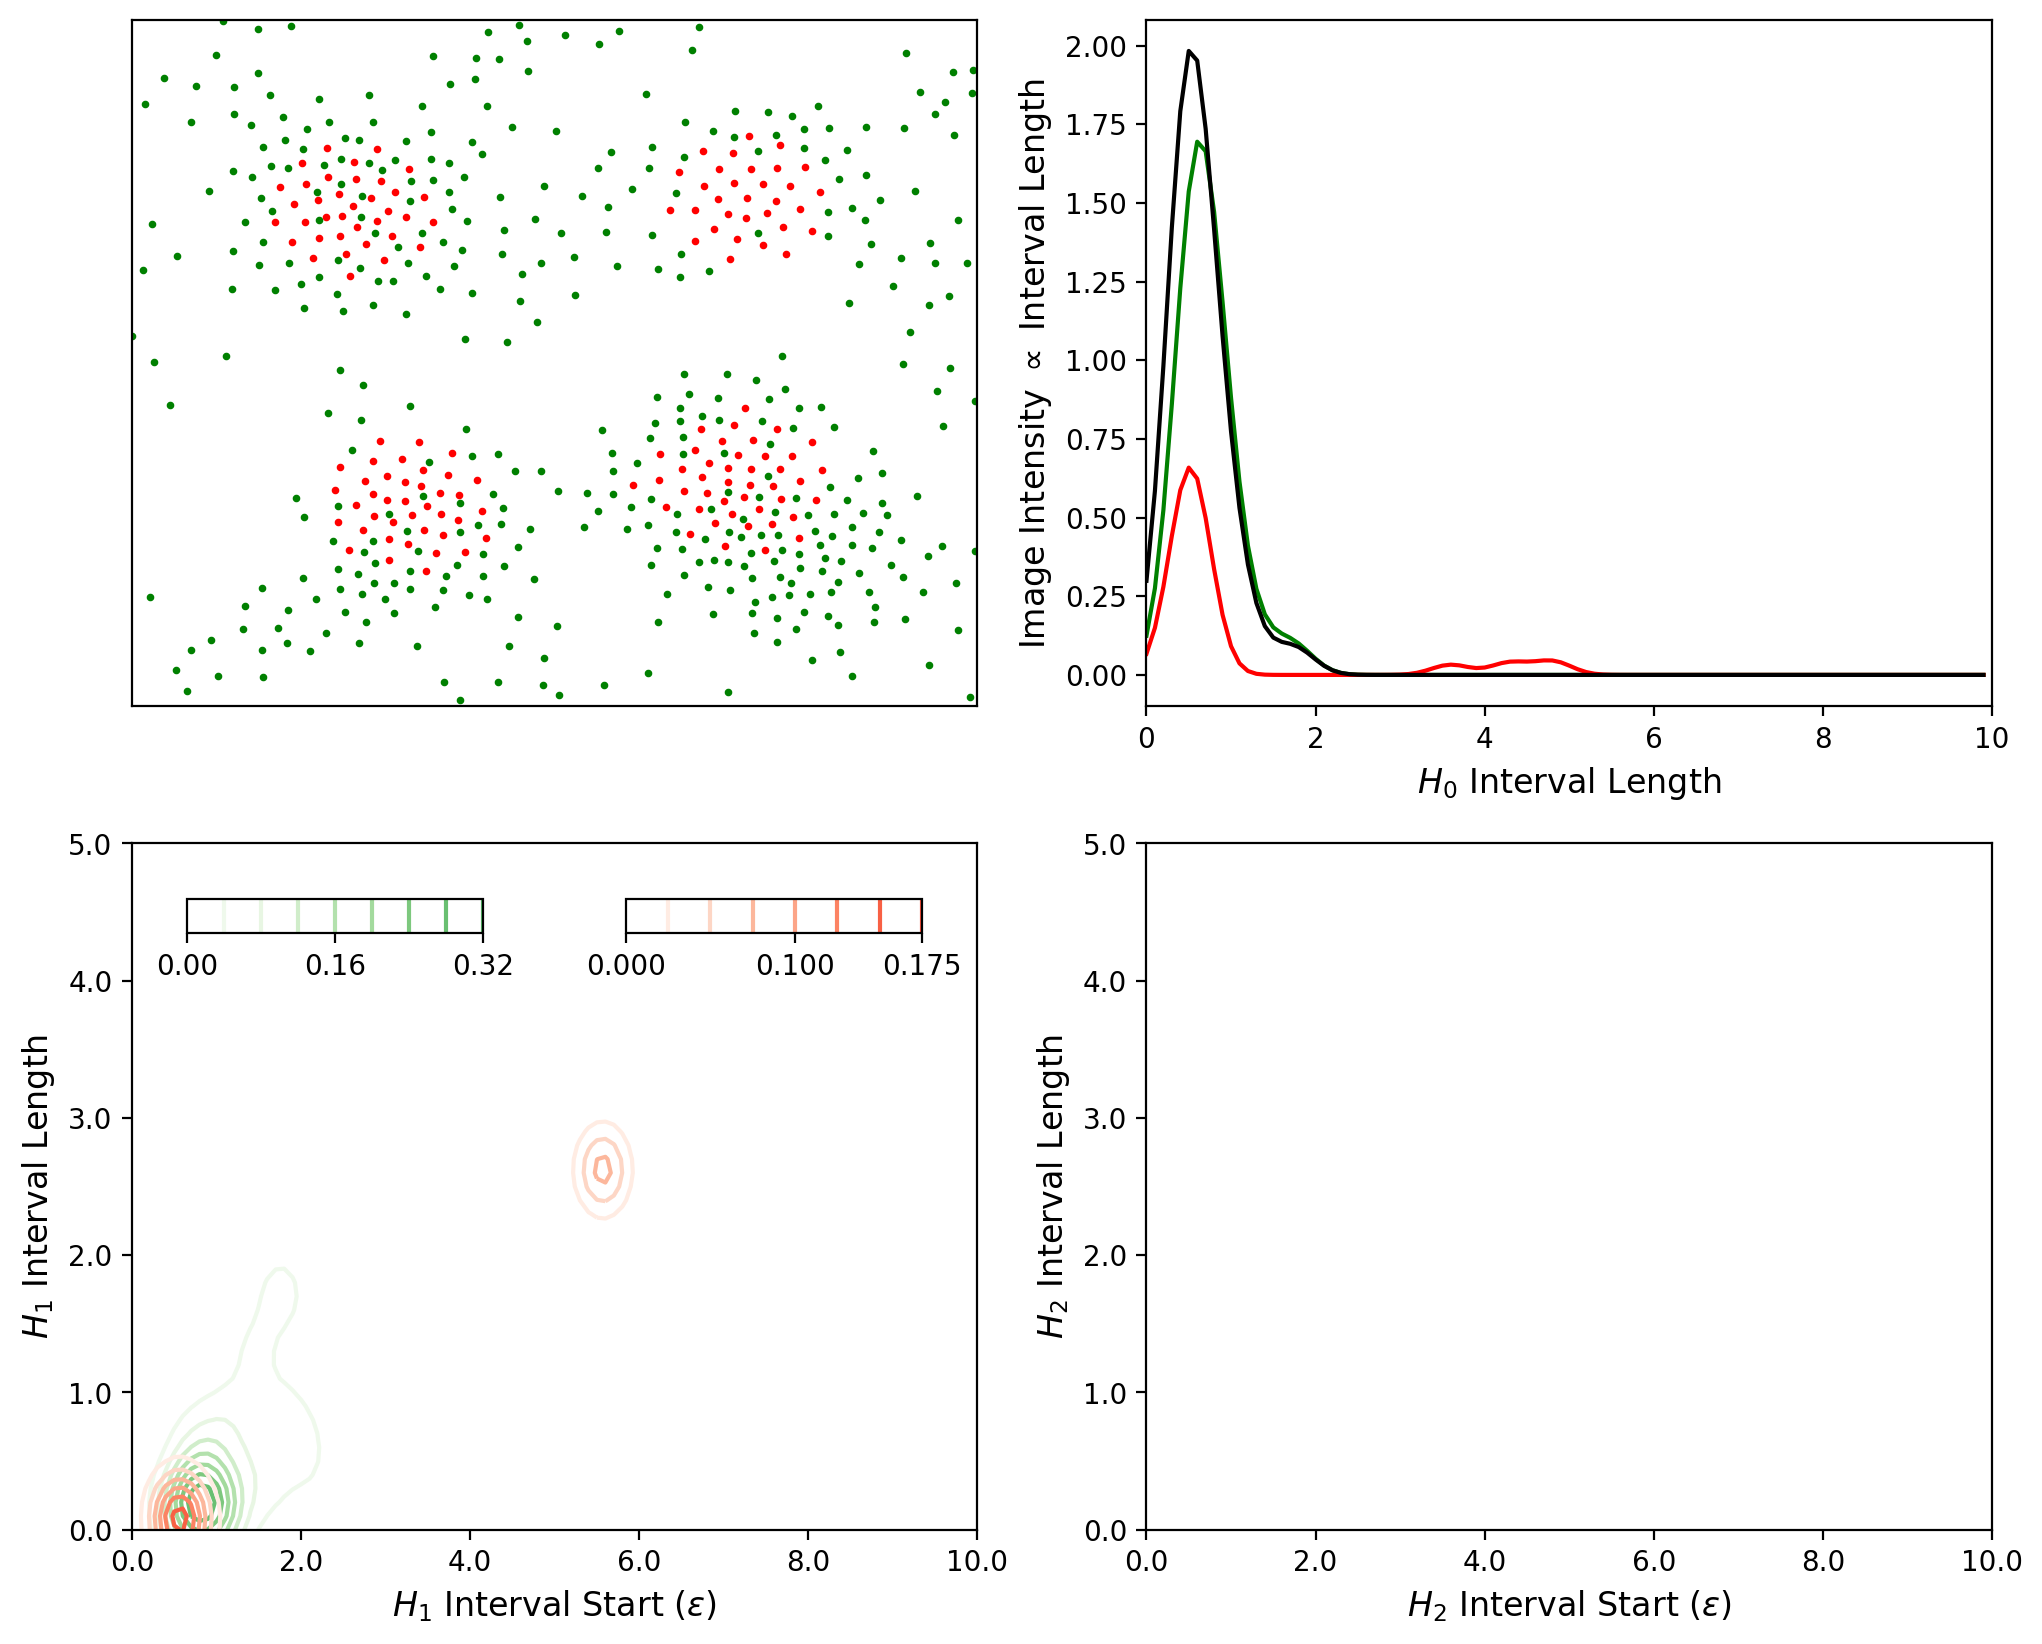

In [5]:
max_eps = 10
px_res = 0.1

for frame in frame_values:

    (cell_pos, cell_type) = get_sim_data(frame, foldername)

    xpos = cell_pos[:,0]
    ypos = cell_pos[:,1]
    greens = cell_type == 1
    reds = cell_type == 2
    greenxpos = xpos[greens]
    greenypos = ypos[greens]
    redxpos = xpos[reds]
    redypos = ypos[reds]

    # print("Processing frame: " + repr(frame))

    (green_img_dim0, red_img_dim0, all_img_dim0) = compute_pers_img(greenxpos, greenypos, redxpos, redypos, 
                                                                    xpos, ypos, 0, max_eps, px_res)

    (green_img_dim1, red_img_dim1, all_img_dim1) = compute_pers_img(greenxpos, greenypos, redxpos, redypos, 
                                                                    xpos, ypos, 1, max_eps, px_res)

    (green_img_dim2, red_img_dim2, all_img_dim2) = compute_pers_img(greenxpos, greenypos, redxpos, redypos, 
                                                                    xpos, ypos, 2, max_eps, px_res)
    save_persimg([green_img_dim0, red_img_dim0, all_img_dim0], 
                 [green_img_dim1, red_img_dim1, all_img_dim1], 
                 [green_img_dim2, red_img_dim2, all_img_dim2],
                 save_folder, repr(frame).zfill(7) + ".npy")

    visualize([greenxpos, greenypos, redxpos, redypos], 
              [green_img_dim0, red_img_dim0, all_img_dim0], 
              [green_img_dim1, red_img_dim1, all_img_dim1], 
              [green_img_dim2, red_img_dim2, all_img_dim2],
              max_eps, px_res, output_folder, repr(frame).zfill(7) + ".png")